# Hierarchical clustering
Based on the keywords given to articles by OpenAlex. see also: https://docs.openalex.org/api-entities/keywords

The data prepared in 01_Clean has been augmented with boolean keyword columns, one column for each keyword. Apply hierarchical clustering to these keywords, to identify structure in the dataset.

In [1]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import pandas as pd
import os
import gc
from matplotlib import pyplot as plt 
    
%matplotlib inline

In [2]:
DATA_PATH = 'data'  # path to folder with (downloaded or generated) data, will not be committed to git
ACRONYM = 'openalex_tng'  # Acronym, aka machine readable name, of this dataset ('tng' stands for "topic netework graph")

In [3]:
# load the data
clean_df = pd.read_csv(os.path.join(DATA_PATH, f"{ACRONYM}_clean.csv.zip"), index_col=0)

### Clustering
1. Extract the keyword columns into a separate dataframe 
2. Linkage method computes distance matrix
3. Create dendrogram
4. fcluster assigns cluster labels to rows.

#### Extract the keyword columns into a separate dataframe 

In [4]:
# keyword columns
colnames = clean_df.columns[14: -34]
keywords_df = clean_df.loc[:, colnames]

#### Linkage method computes distance matrix
* Distance metric: Using 'cityblock' (aka manhattan distance) instead of default 'euclidean', as keyword columns are boolean.
* Clustering method: As using non-euclidean distance, method 'single' is applied to clustering.

In [5]:
# compute distance matrix Z
Z = linkage(keywords_df, method = 'complete', metric = 'cityblock', optimal_ordering=True)

#### Create dendrogram
* x-axis: distance between clusters
* y-axis: dissimilarity between clusters
  

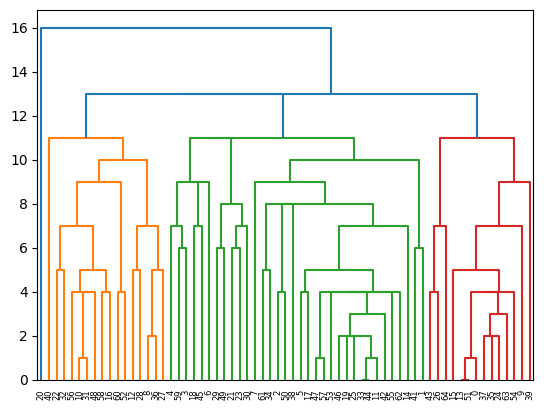

In [6]:
dn = dendrogram(Z)
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

#### fcluster assigns cluster labels to rows

In [7]:
clean_df['cluster_label'] = fcluster(Z, 4, criterion='maxclust')
clean_df.groupby('cluster_label').size()

cluster_label
1    16
2    34
3    14
4     1
dtype: int64

Discard cluster(s) which contain only one article: papers that have their own cluster are handled as oulyers and discarded.

In [8]:
cluster_labels = clean_df['cluster_label'].unique()
groups = clean_df.groupby('cluster_label')
singleton_clusters = []
for cluster in cluster_labels:
    # document count in cluster
    if groups.size()[cluster] <= 1:
        singleton_clusters.append(cluster)

# discard papers in singleton clusters
for singleton in singleton_clusters:
    idx = clean_df['cluster_label'] == singleton
    clean_df = clean_df[~idx]

## Label each cluster
* Count occurrences of keywords by cluster
* Use LLM to label each cluster based on keywords

In [9]:
MIN_OCCURRENCES = 1  # the minimum number of papers that have a keyword for the keyword to count  
cluster_labels = clean_df['cluster_label'].unique()
label_keywords = {}
for label in cluster_labels:
    # get all articles with this label
    idx = clean_df['cluster_label'] == label
    articles_by_label = clean_df[idx]
    # count occurrences of keywords for articles by label
    keywords_by_label_df = articles_by_label.loc[:, colnames]  # colnames = names of keyword columns
    keywords_counts = keywords_by_label_df.sum().sort_values(ascending=False)
    # keep only entries with at least MIN_OCCURRENCES occurrence
    keywords_counts = keywords_counts[keywords_counts >= MIN_OCCURRENCES]
    label_keywords[label]= keywords_counts

In [10]:
MAX_KEYWORDS = 30
# For each label, concatenate the keywords as a comma-sparated string (ordered by count ascending)
topics = {label:', '.join(keywords[:MAX_KEYWORDS].index) for label,keywords in label_keywords.items()}

### Using Llama gated model

Prerequisites
* Go to huggingface, login, go to settings/access tokens
* Create a new READ token, save it to ../token.txt (the token will not be committed to git repo, check .gitignore)
* Go here: https://huggingface.co/meta-llama/Meta-Llama-3.1-8B-Instruct and accept the usage conditions

In [11]:
# Login programmatically (after creating token and accepting usage conditions, see above)
from huggingface_hub import login
with open('./token.txt', 'r') as handle:
    token = handle.read()
login(token=token)

/home/kobv/atroncos/topic_network_graphs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/kobv/atroncos/.cache/huggingface/token
Login successful


In [12]:
import transformers
import torch
from abc import ABC, abstractmethod


class Promptable(ABC):
    """Abstract class for LLM wrappers."""

    @abstractmethod
    def predict_label(self, system_msg, user_msg): 
        """Prompts the LLM to predict a label for a topic described by list of keywords.

        @param system_msg: content of the system message (string)
        @param terms: content of the user message (string)
        @returns: response string
        """
        pass


class Manegeable(ABC):
    """Abstract class for classes that can be instatiated using the 'with' statement."""

    @abstractmethod
    def __enter__(self): 
        """Called when the wrapper is instantiated via the python "with" statement."""
        pass

    @abstractmethod
    def __exit__(self, *args):
        """Called when the wrapper is disposed of via the python "with" statement."""
        pass


class Llama(Promptable, Manegeable):
    """A wrapper class for the Llama LLM."""

    def __init__(self):
        self.model_id="meta-llama/Meta-Llama-3.1-8B-Instruct"

    def predict_label(self, system_msg, user_msg):
        """Overrides abstract method from Promptable."""
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_msg},
        ]
        outputs = self.pipeline(
            messages,
        )
        return outputs[0]["generated_text"][-1]['content']

    def __enter__(self):
        """Overrides abstract method from Manageable."""
        self.pipeline = transformers.pipeline(
            "text-generation",
            model=self.model_id,
            model_kwargs={"torch_dtype": torch.bfloat16},
            max_new_tokens=200,
            device_map="auto",
            do_sample=False,
            temperature=0.1
        )
        return self

    def __exit__(self, *args):
        """Overrides abstract method from Manageable."""
        del self.pipeline
        # release GPU memory
        gc.collect()  # explicitly call garbage collector
        torch.cuda.empty_cache()

In [13]:
CATEGORY = "Bibliometric Analysis and Research Evaluation"  # primary topic of dataset from OpenAlex

topic_nums = []  # the numervcal identifeir of the topic, as given by clustering
topic_keywords = []  # the keywords for each topic
labels = []  # the labe predicted by the LLM
system_msg = f"You are an AI assistant specialised in {CATEGORY}"
user_msg = f"""
    What short, concise and human-readable labels best describe the topics characterised by these terms? 
    Output one label for each of the {len(topics)} topics. 
    Make each label as different as possible from the other labels. 
    """
with Llama() as model:
    for topic_num,terms in topics.items():
        topic_nums.append(topic_num)
        topic_keywords.append(terms)
        user_msg += f"Topic {topic_num}: {terms}. "
    response = model.predict_label(system_msg, user_msg)
print(response)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  7.39it/s]
Some parameters are on the meta device device because they were offloaded to the cpu.
/home/kobv/atroncos/topic_network_graphs/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/kobv/atroncos/topic_network_graphs/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Based on the provided terms, I've identified three distinct topics and assigned a concise, human-readable label to each:

**Topic 1: Research Quality and Impact Assessment**
This topic focuses on evaluating the quality and impact of research, including bibliometric analysis, citation analysis, and scientific impact assessment.

**Topic 2: Research Collaboration and Open Science**
This topic explores the dynamics of research collaboration, including co-authorship networks, interdisciplinary research, and open science practices, such as open access publishing and data sharing.

**Topic 3: Research Information Science and Data Management**
This topic delves into the science of research information, including citation analysis, data citation, and scientific data management, as well as the use of digital tools and methods for research evaluation, such as bibliometric analysis and social network analysis.


Parse the response to extract the predicted labels.

In [14]:
labels = []
for line in response.split('\n'):
    if len(line) > 0 and "Topic" in line:
        label = line.split(':')[-1].strip().strip('"').strip('**')
        labels.append(label)

In [15]:
labels_df = pd.DataFrame.from_dict({'topic_number':topic_nums, 'keywords':topic_keywords})  # make a dataframe from topic number and keywords
labels_df.sort_values('topic_number', ignore_index=True, inplace=True)  # sort by topic number
labels_df['label'] = labels # add the labels (which are sorted by topic number in the LLM response)
labels_df['article_count'] = clean_df.groupby('cluster_label').size().values  # add article counts
labels_df

,topic_number,keywords,label,article_count
0,1,"Research Evaluation, Bibliometric Analysis, Sc...",Research Quality and Impact Assessment,16
1,2,"Research Evaluation, Collaboration Patterns, I...",Research Collaboration and Open Science,34
2,3,"Interdisciplinary Research, Citation analysis,...",Research Information Science and Data Management,14


## Sort articles
For each cluster, list the articles sorted by citation_normalized_percentile.value

In [16]:
ARTICLE_CITATION_PERCENTILE = 0.95

def format_article(article):
    authorships = article['authorships.author.display_name'].replace("\n", '')
    resp = f"""{article['authorships.author.display_name']}({article['publication_year']}). {article['primary_location.source.display_name']}.{article['title']}. {article['doi']}.
    """
    return resp

for topic_number in labels_df['topic_number']:
    label = labels_df[labels_df['topic_number']==topic_number]['label'].to_string(index=False)
    idx = clean_df['cluster_label'] == topic_number

    # sort articles by citation percentile value (as provided by OpenAlex)
    articles = clean_df[idx].sort_values('citation_normalized_percentile.value', ascending=False)
    # keep articles in 95% percentile (as set in ARTICLE_CITATION_PERCENTILE)
    idx = articles['citation_normalized_percentile.value'] >= ARTICLE_CITATION_PERCENTILE
    articles = articles[idx]

    # format and print references to chosen articles, by topic
    articles_formatted = []
    for article_id in articles.index:
        article = clean_df.loc[article_id]
        articles_formatted.append(format_article(article))        
    print(f"""
        {label}\n
        ==================
        {"".join(articles_formatted)}
    """)



        Research Quality and Impact Assessment

        Jianguo Xu|Mengjun Li|Jiang Jiang|Bingfeng Ge|Mengsi Cai(2019). IEEE Access.Early Prediction of Scientific Impact Based on Multi-Bibliographic Features and Convolutional Neural Network. https://doi.org/10.1109/access.2019.2927011.
    Giacomo Vaccario|Matúš Medo|Nicolas Wider|Manuel Sebastian Mariani(2017). Journal of Informetrics.Quantifying and suppressing ranking bias in a large citation network. https://doi.org/10.1016/j.joi.2017.05.014.
    Pavel Savov|Adam Jatowt|Radosław Nielek(2020). Information Processing & Management.Identifying breakthrough scientific papers. https://doi.org/10.1016/j.ipm.2019.102168.
    Michael Färber|Lazaros Tampakis(2023). Scientometrics.Analyzing the impact of companies on AI research based on publications. https://doi.org/10.1007/s11192-023-04867-3.
    
    

        Research Collaboration and Open Science

        Emre Sarigöl|René Pfitzner|Ingo Scholtes|Antonios Garas|Frank Schweitzer(2014). E